In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pymc3 as pm
from datetime import datetime as dt

sns.set_style('whitegrid')

### Data

In [17]:
df = pd.read_csv("./data/Price/Task 1/Task1_P.csv")

# cleaning
df.columns = ['zone_id','timestamp','system_load','zonal_load','price']
df['timestamp'] = df.timestamp.apply(lambda x: dt.strptime(x, '%m%d%Y %H:%M'))
df['day'] = df.timestamp.dt.date
df['hour'] = df.timestamp.dt.hour
df['weekday'] = df.timestamp.dt.weekday

# set main datetime index
df = df.set_index('timestamp')

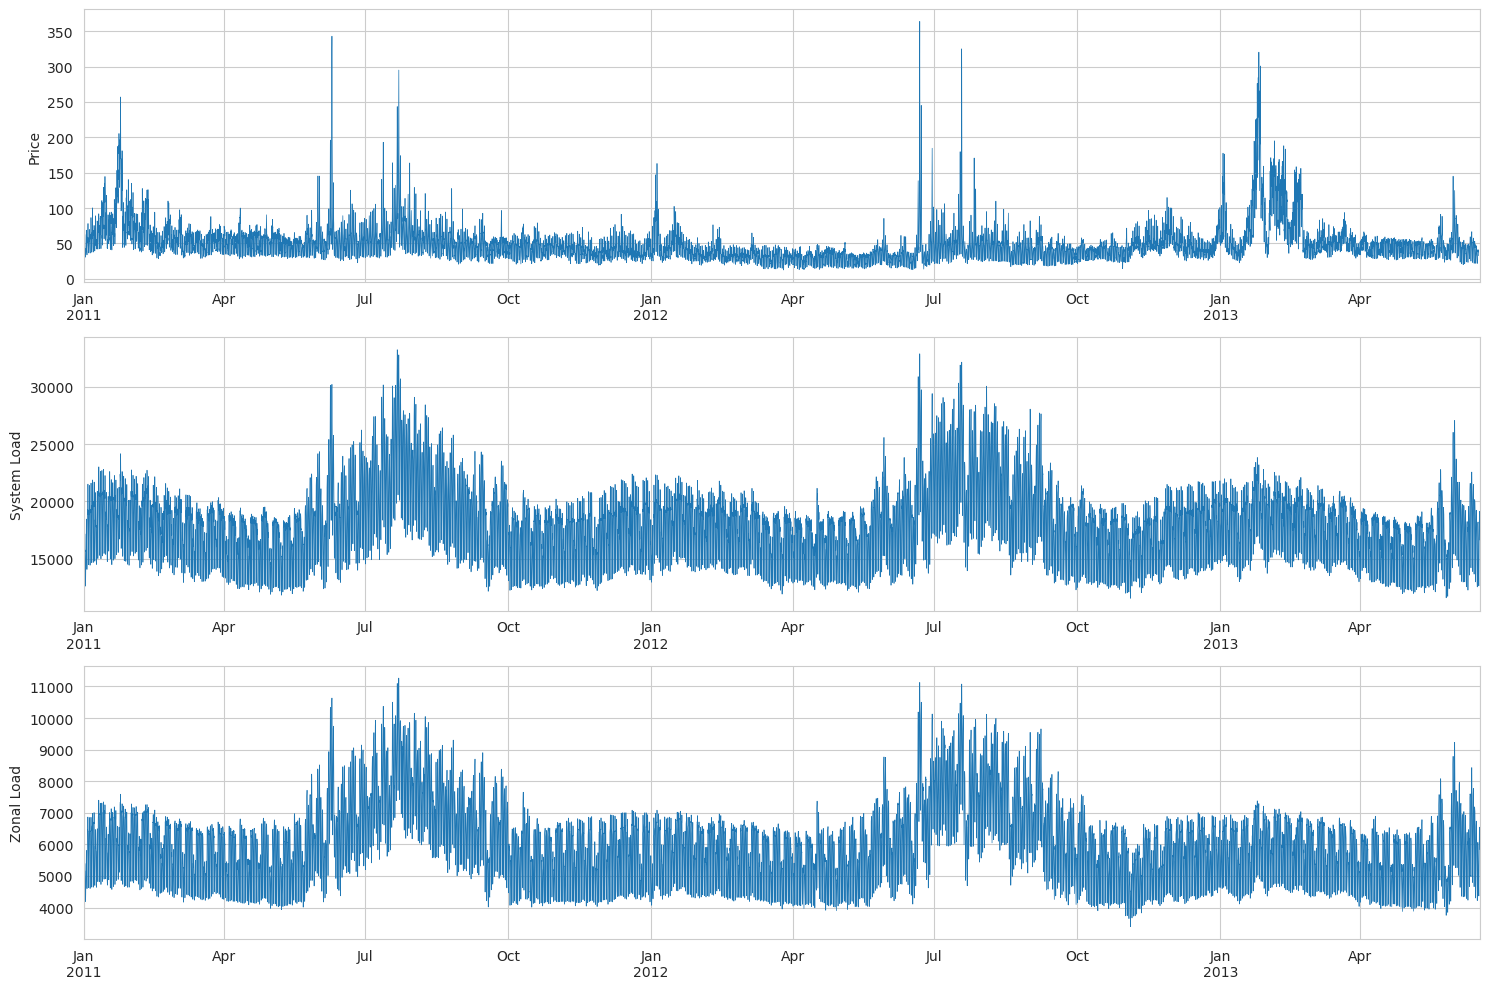

In [14]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

df.price.plot(ax=axes[0], lw=0.5)
axes[0].set_xlabel("")
axes[0].set_ylabel("Price")

df.system_load.plot(ax=axes[1], lw=0.5)
axes[1].set_xlabel("")
axes[1].set_ylabel("System Load")

df.zonal_load.plot(ax=axes[2], lw=0.5)
axes[2].set_xlabel("")
axes[2].set_ylabel("Zonal Load")

fig.tight_layout()
fig.show()

### Metrics

In [18]:
def crps(x_hats, x, qs):
    """
    Continuous Ranked Probability Score
    Estimated using discretization of Pinball Scores at each quantile
    
    paramters:
    ----------
    x: float, the realization observed
    x_hats: array of float, the prediction of x at all q-th quantile from 1% to 99%
    qs: array of float, the q-th quantiles ∈ [0, 1] predictions provided
    """
    errors = np.abs(x - x_hats)
    weights = np.where(x >= x_hats, qs, 1-qs)
    return (errors * weights).sum()

def unconditional_coverage(y_true, y_lbs, y_ubs):
    """
    Unconditional Coverage of a quantile bound

    parameters:
    -----------
    y_true: array of float, the true observations
    y_lbs: array of float, the predicted lower bounds
    y_ubs: array of float, the predicted upper bounds
    """
    # remove any entry that is nan
    has_nan = np.isnan(y_true) | np.isnan(y_lbs) | np.isnan(y_ubs)
    is_covered = ((y_true >= y_lbs) & (y_true <= y_ubs))[~has_nan]
    return np.mean(is_covered)

### Benchmark Algorithm

In [136]:
# set up benchmark - naive
naive = df.copy()
naive['last_week_price'] = naive.shift(24*7).price
naive['last_day_price'] = naive.shift(24).price
naive['price_predict'] = naive.apply(lambda x: x.last_day_price if x.weekday in (1,2,3,4) else x.last_week_price, axis=1)

window_size = 182
qs = np.linspace(1, 99, 99) / 100

# rolling PI window estimation, done indepdently per hour
stats = []
for hour in range(24):
    window = naive[naive.hour==hour].rolling(window_size+1, min_periods=window_size+1)
    
    for chunk in window:
        ts = chunk.index[-1]

        # window chunk with not enough data
        if chunk.shape[0] != (window_size+1):
            stats.append((ts, np.nan, np.nan, np.nan))
            continue

        # chunk with enough data
        y_hat = chunk.price_predict.iloc[-1]
        chunk_history = chunk.iloc[:-1]
        y_hats = (chunk_history.price - chunk_history.price_predict).quantile(qs).values + y_hat

        y = chunk.price.iloc[-1]
        if np.isnan(y):
            stats.append((ts, y_hats[4], y_hats[94], np.nan))
        else:
            stats.append((ts, y_hats[4], y_hats[94], crps(y_hats, y, qs)))

naive[['predict_q5','predict_q95', 'crps']] = pd.DataFrame(stats, columns=['timestamp', 'predict_q5', 'predict_q95', 'crps']).set_index('timestamp')
naive['predict_uc'] = (naive.price <= naive.predict_q95) & (naive.price >= naive.predict_q5)

In [611]:
unconditional_coverage(naive.price, naive.predict_q5, naive.predict_q95)

0.8796037296037296

<AxesSubplot:xlabel='hour'>

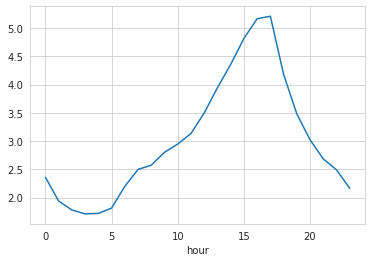

In [662]:
(naive.groupby('hour').crps.mean() / qs.shape[0]).plot()

<AxesSubplot:xlabel='hour'>

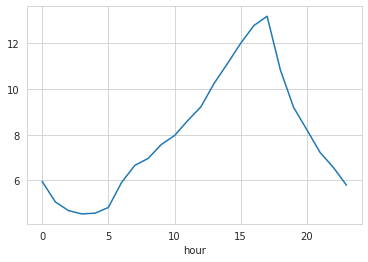

In [613]:
naive.groupby('hour').apply(lambda x: np.abs(x.price - x.price_predict).mean()).plot()

<AxesSubplot:xlabel='timestamp'>

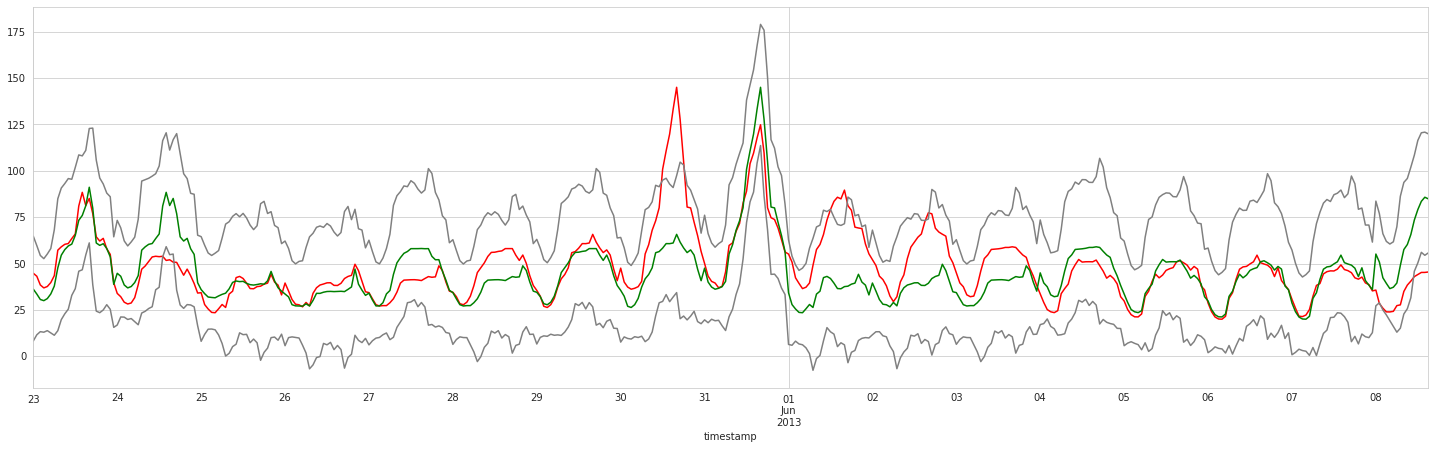

In [655]:
fig, ax = plt.subplots(figsize=(25, 7))
naive.iloc[-600:-200, :].price.plot(color='red')
naive.iloc[-600:-200, :].price_predict.plot(color='green')
naive.iloc[-600:-200, :].predict_q95.plot(color='grey')
naive.iloc[-600:-200, :].predict_q5.plot(color='grey')

### ARX Model Prediction

In [22]:
arx = df.copy()

In [23]:
window_size = 365

arx['log_price'] = np.log(arx.price)
arx['log_zonal_load'] = np.log(arx.zonal_load)
# hourly indepdent simple moving average of the last window used current estimation
arx['yearly_logmean'] = arx.groupby('hour').rolling(window=window_size+1, min_periods=window_size).price.apply(lambda x: np.mean(np.log(x.iloc[:-1]))).droplevel(0)
arx['centered_log_price'] = arx.log_price - arx.yearly_logmean

arx['clp[-1 day]'] = arx.centered_log_price.shift(24*1)
arx['clp[-2 day]'] = arx.centered_log_price.shift(24*2)
arx['clp[-7 day]'] = arx.centered_log_price.shift(24*7)

arx['clp[-1 day]min'] = arx.groupby('day')['clp[-1 day]'].min()
arx['clp[-1 day]min'] = arx['clp[-1 day]min'].fillna(method='ffill')

arx['is_sat'] = (arx.weekday == 5).astype(int)
arx['is_sun'] = (arx.weekday == 6).astype(int)
arx['is_mon'] = (arx.weekday == 0).astype(int)

In [231]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

feature_cols = ['clp[-1 day]', 'clp[-2 day]', 'clp[-7 day]', 'clp[-1 day]min', 'is_sat', 'is_sun', 'is_mon', 'log_zonal_load']
step = 1
pred_horizon = step
start_t = (365 + 6) * step
training_t = 182 * step

# the nested training and prediction procedure
stats = []
for hour in range(24):
    a = arx[arx.hour==hour].iloc[start_t:, :]
    for i in range(int((a.shape[0]-training_t) // step)):
        start = step*i
        end = start + training_t

        ts = a.index[end+pred_horizon-1]

        X_train = a[feature_cols].iloc[start:end, :]
        y_train = a['centered_log_price'].iloc[start:end]
        y_train_intercept = a['yearly_logmean'].iloc[start:end]

        X_test = a[feature_cols].iloc[end:end+pred_horizon, :]
        y_test_intercept = a['yearly_logmean'].iloc[end:end+pred_horizon].values
        y_true = a.price.iloc[end:end+pred_horizon]

        ols = LinearRegression(fit_intercept=False)
        ols.fit(X_train, y_train)

        y_res = np.exp(pd.Series(ols.predict(X_train).ravel(), index=X_train.index) + y_train_intercept) - np.exp(y_train + y_train_intercept)
        y_hat = np.exp(ols.predict(X_test) + y_test_intercept)[0]
        y_qs = y_res.quantile(qs).values + y_hat
        stats.append((ts, y_hat, y_qs[4], y_qs[94], crps(y_qs, y_true[0], qs)))

arx[['price_predict', 'predict_q5','predict_q95', 'crps']] = pd.DataFrame(stats, columns=['timestamp', 'price_predict', 'predict_q5', 'predict_q95', 'crps']).set_index('timestamp')
arx['predict_uc'] = (arx.price <= arx.predict_q95) & (arx.price >= arx.predict_q5)

In [232]:
unconditional_coverage(arx.price, arx.predict_q5, arx.predict_q95)

0.8390261627906976

Text(0.5, 1.0, 'CRPS')

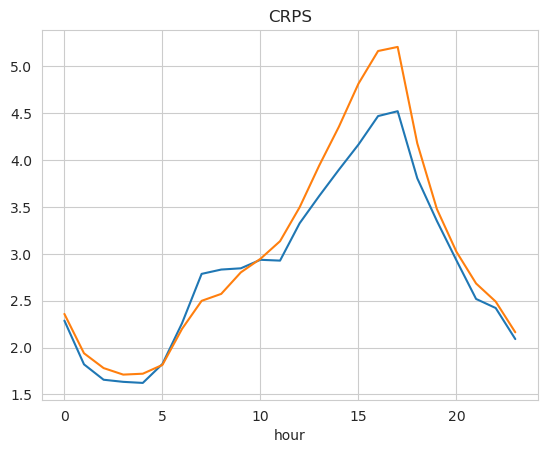

In [233]:
(arx.groupby('hour').crps.mean() / qs.shape[0]).plot()
(naive.groupby('hour').crps.mean() / qs.shape[0]).plot()
plt.title('CRPS')

Text(0.5, 1.0, 'MAE')

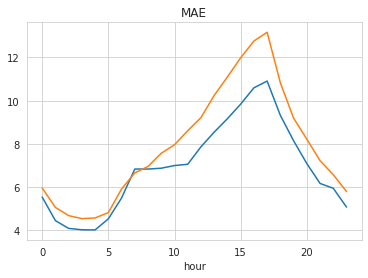

In [648]:
arx.groupby('hour').apply(lambda x: np.abs(x.price - x.price_predict).mean()).plot()
naive.groupby('hour').apply(lambda x: np.abs(x.price - x.price_predict).mean()).plot()
plt.title('MAE')

In [1]:
fig, ax = plt.subplots(figsize=(25, 7))
arx.iloc[-600:-200, :].price.plot(color='green')
arx.iloc[-600:-200, :].price_predict.plot(color='orange')
arx.iloc[-600:-200, :].predict_q95.plot(color='grey', linestyle=':')
arx.iloc[-600:-200, :].predict_q5.plot(color='grey', linestyle=':')

NameError: name 'plt' is not defined

<AxesSubplot:xlabel='timestamp'>

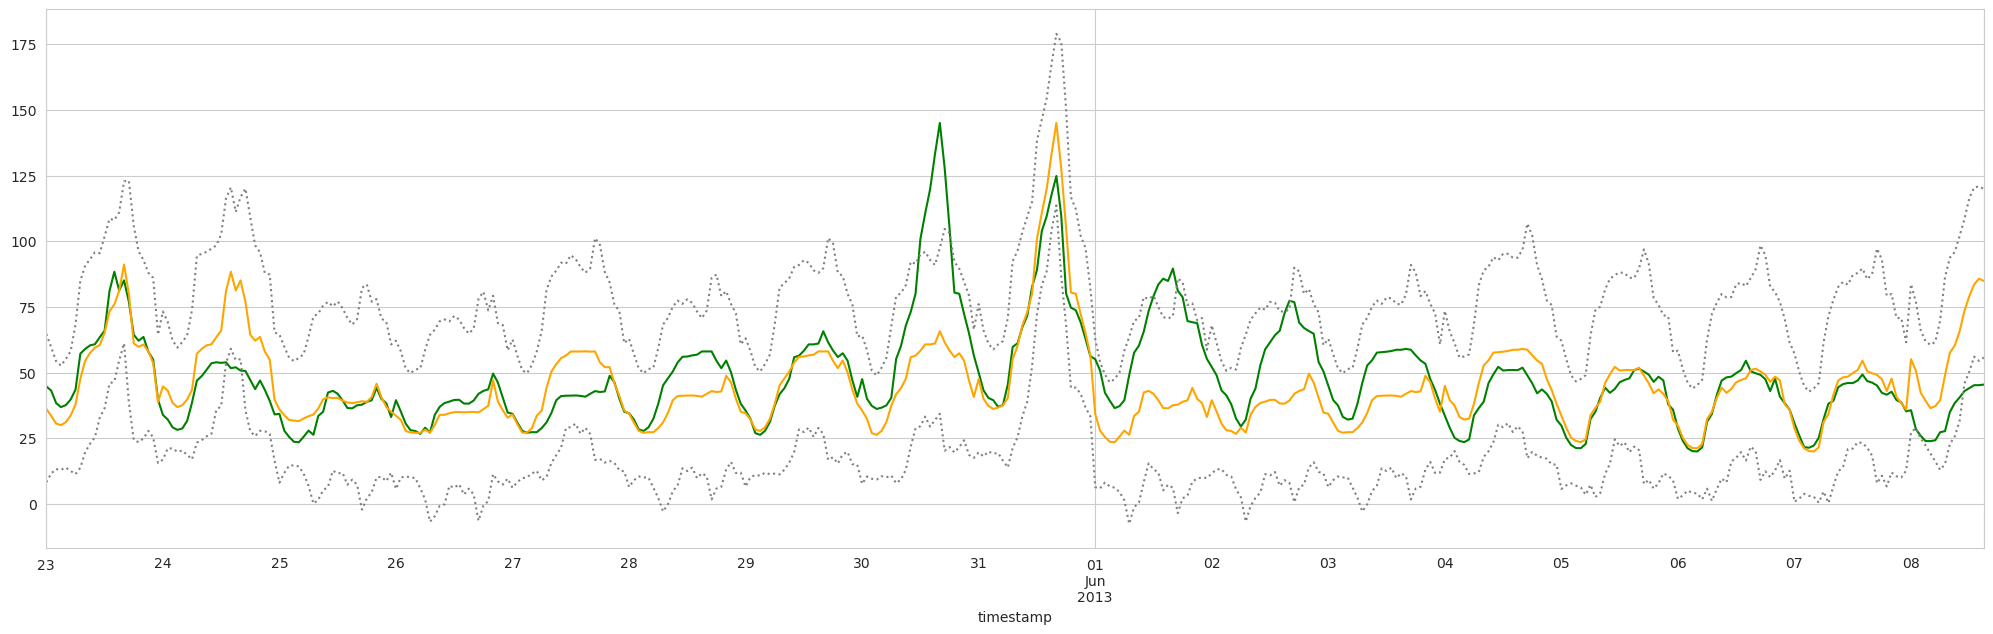

In [21]:
fig, ax = plt.subplots(figsize=(25, 7))
naive.iloc[-600:-200, :].price.plot(color='green')
naive.iloc[-600:-200, :].price_predict.plot(color='orange')
naive.iloc[-600:-200, :].predict_q95.plot(color='grey', linestyle=':')
naive.iloc[-600:-200, :].predict_q5.plot(color='grey', linestyle=':')

### GM-HMM

In [57]:
import numpy as np
import pandas as pd
import pymc3 as pm
import patsy
import theano
import theano.tensor as tt
import arviz as ar

from pymc3 import Model, Data, Normal, Gamma, Dirichlet, Deterministic
from pymc3_hmm.utils import compute_steady_state
from pymc3_hmm.distributions import SwitchingProcess, DiscreteMarkovChain
from pymc3_hmm.step_methods import FFBSStep

In [20]:
def create_arx_hmm_model(X, y=None):
    """
    Create the graph for AutoRegressive with Extra Input on Hidden Markov Model (ARX-HMM)
    """
    with pm.Model() as model:
        X_tt = pm.Data("data", X)

        # linear regression conditional on hidden states
        β1 = Normal("β1", 0, tau=1/100, shape=X.shape[1])
        β2 = Normal("β2", 0, tau=1/100, shape=X.shape[1])

        conditional_dists = [
            Normal.dist(
                mu=tt.tensordot(X_tt, β1, axes=((1,), (0,))),
                tau=Gamma("τ1", alpha=1, beta=1/20)
            ),
            Normal.dist(
                mu=tt.tensordot(X_tt, β2, axes=((1,), (0,))),
                tau=Gamma("τ2", alpha=1, beta=1/20)
            ),
        ]

        # time invariant state transition prior
        A0 = Dirichlet("A0", np.r_[1, 1])
        A1 = Dirichlet("A1", np.r_[1, 1])
        A = Deterministic("A_t", tt.shape_padleft(tt.stack([A0, A1])))

        # initial hidden state prior
        π = compute_steady_state(A)

        # the 1-st order MM of the hidden state
        S_rv = DiscreteMarkovChain("S_t", A, π, shape=X.shape[0])

        # likelihood that calculates the conditional density on the hidden state
        observed = np.zeros(X.shape[0]) if y is None else y  # dummy placeholder
        likelihood = SwitchingProcess("Y_t", conditional_dists, S_rv, observed=observed)
    
    return model

In [192]:
def get_train_test(data, hour):
    X_train = data[data.hour==0].dropna()[['clp[-1 day]', 'clp[-2 day]', 'clp[-7 day]', 'clp[-1 day]min', 'log_zonal_load', 'is_sat', 'is_sun', 'is_mon']].values
    y_train = data[data.hour==0].dropna()['centered_log_price'].values

    X_test = data[data.hour==0][['clp[-1 day]', 'clp[-2 day]', 'clp[-7 day]', 'clp[-1 day]min', 'log_zonal_load', 'is_sat', 'is_sun', 'is_mon']].iloc[-1, :]
    X_test = np.expand_dims(X_test.values, axis=0)

    return X_train, y_train, X_test

def create_model_all_hours():
    models = {}
    for h in range(24):
        X_train, y_train, X_test = get_train_test(arx, h)
        models[h] = {
            'X_train': X_train,
            'y_train': y_train,
            'X_test': X_test,
            'train_model': create_arx_hmm_model(X_train, y_train),
            'test_model': create_arx_hmm_model(X_test, None)
        }
    return models

In [193]:
models = create_model_all_hours()

In [197]:
for h, model_meta in models.items():
    with model_meta['train_model'] as m:
        states_step = FFBSStep([m.S_t])
        mu_step = pm.NUTS([
            m.β1, m.β2,
            m.τ1, m.τ2,
            m.A0, m.A1
        ])

        posterior_trace = pm.sample(
            2000, tune=1000,
            step=[states_step, mu_step],
            return_inferencedata=True,
            chains=1,
            progressbar=True,
        )
        models[h]['posterior_trace'] =  posterior_trace

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{Cast{float64}}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{Cast{float64}}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{Cast{float64}}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{log,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.t

Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 94 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{gt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{log,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construc

Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 98 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{gt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{log,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construc

Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 92 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{gt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{log,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construc

Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 95 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{gt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{log,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construc

Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 101 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{gt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{log,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot constru

Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 100 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{gt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{log,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot constru

Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 96 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{gt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{log,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construc

Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 93 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{gt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{log,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construc

Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 103 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{gt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{log,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot constru

Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 96 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{gt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{log,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construc

Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 91 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{gt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{log,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construc

Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 98 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{gt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{log,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construc

Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 98 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{gt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{log,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construc

Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 93 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{gt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{log,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construc

Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 98 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{gt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{log,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construc

Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 99 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{gt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{log,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construc

Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 93 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{gt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{log,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construc

Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 96 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{gt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{log,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construc

Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 98 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{gt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{log,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construc

Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 100 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{gt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{log,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot constru

Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 95 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{gt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{log,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construc

Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 103 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{gt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{log,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot constru

Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 93 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{gt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{log,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construc

Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 95 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{gt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{log,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor.0
WARNING (theano.tensor.opt): Cannot construc

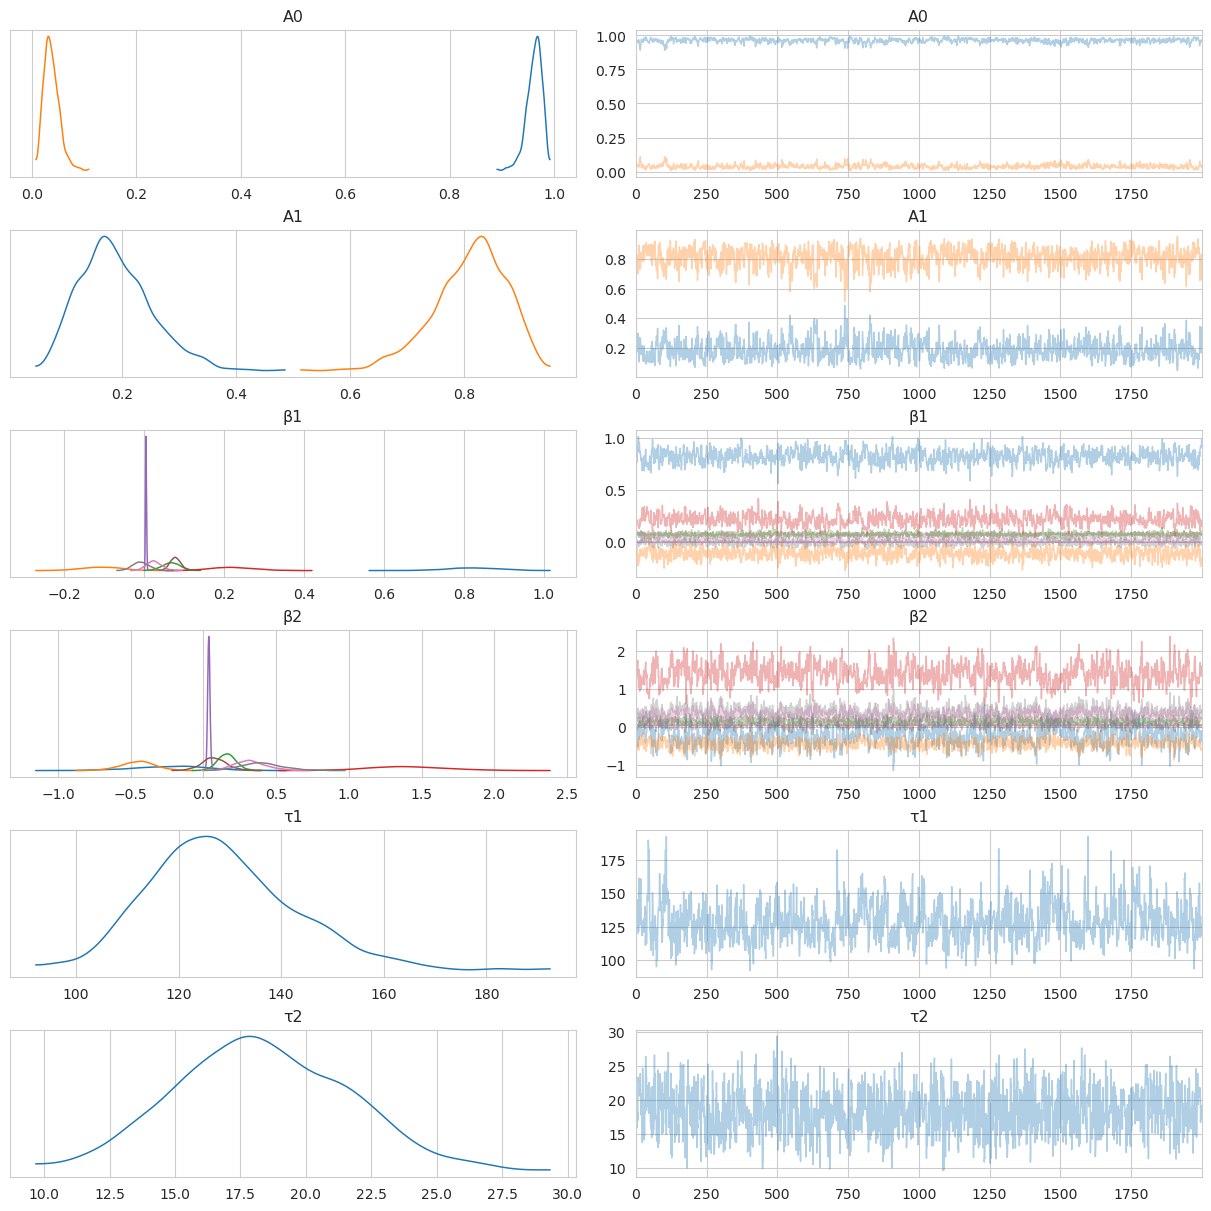

In [200]:
ax = ar.plot_trace(models[15]['posterior_trace'], var_names=["A0", "A1", 'β1', 'β2', 'τ1', 'τ2'])

In [201]:
for h, model_meta in models.items():
    with model_meta['test_model'] as m:
        out_of_sample_pp = pm.sample_posterior_predictive(
            trace=posterior_trace.posterior.drop_vars(["S_t"]), var_names=["Y_t"],
            samples=500, model=m
        )
        models[h]['oos_pp'] =  out_of_sample_pp

/home/ztang484/workplace/duke/sta571-fa22/project/env/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [248]:
y_true = [34.02, 28.26, 24.82, 22.9, 21.59, 21.33, 21.55, 22.49, 26.25, 28.95, 32.17, 32.44, 34.25, 35.97, 38.05, 37.77, 40.87, 37.51, 35.44, 35.28, 37.55, 38.41, 35, 32.31]
crps_scores = []
for h, model_meta in models.items():
    a = model_meta['oos_pp']
    y_hats = (np.exp(a['Y_t'] + arx[arx.hour==h]['yearly_logmean'].iloc[-1])).ravel()
    crps_scores.append(crps(pd.Series(y_hats).quantile(qs), y_true[h], qs) / qs.shape[0])

In [254]:
y_true[h]

32.31

<AxesSubplot:ylabel='Density'>

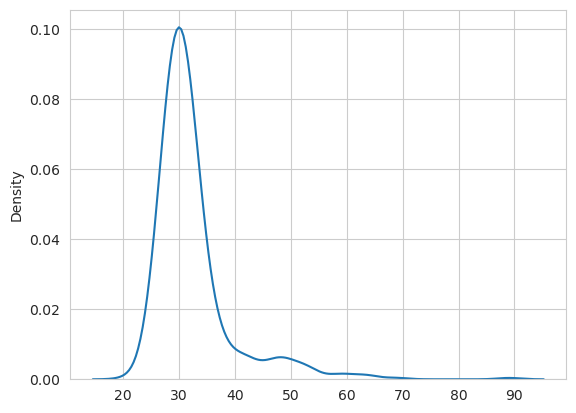

In [257]:
sns.kdeplot(y_hats)

In [263]:
pd.Series(crps_scores)

0     1.270311
1     0.554157
2     0.401456
3     0.439667
4     0.825772
5     1.822462
6     3.908279
7     4.880899
8     3.957053
9     3.903619
10    3.205433
11    3.586604
12    2.673873
13    2.004337
14    1.295227
15    1.693288
16    1.530505
17    3.844454
18    3.574833
19    3.346737
20    1.629586
21    0.583065
22    0.557374
23    0.620687
dtype: float64

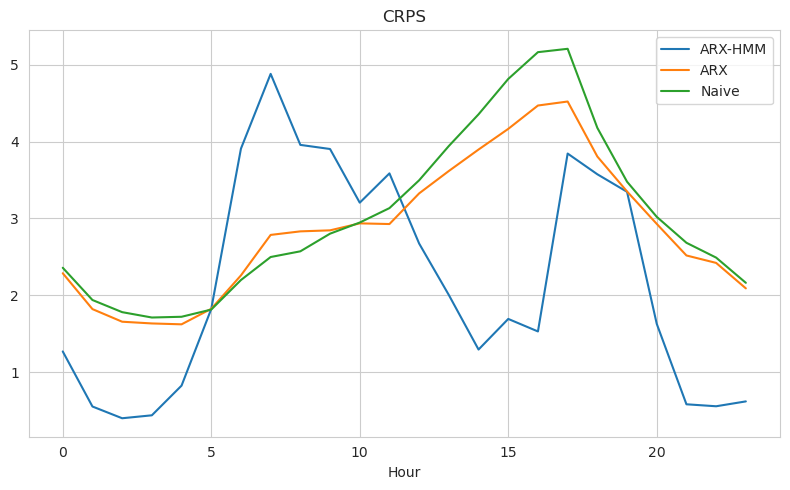

In [269]:
fig, ax = plt.subplots(figsize=(8, 5))

pd.Series(crps_scores).plot(ax=ax, label='ARX-HMM')
(arx.groupby('hour').crps.mean() / qs.shape[0]).plot(ax=ax, label='ARX')
(naive.groupby('hour').crps.mean() / qs.shape[0]).plot(ax=ax, label='Naive')

ax.set_title('CRPS')
ax.set_xlabel('Hour')
ax.legend()

fig.tight_layout()
fig.show()

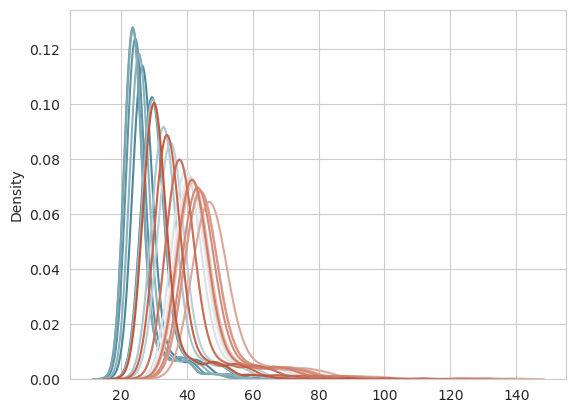

In [216]:
cmap = sns.diverging_palette(220, 20, n=24)
for h, model_meta in models.items():
    y_hats = (np.exp(a['Y_t'] + arx[arx.hour==h]['yearly_logmean'].iloc[-1])).ravel()
    sns.kdeplot(y_hats, color=cmap[h])

In [146]:
print(pd.Series((np.exp(out_of_sample_pp['Y_t'] + arx[arx.hour==0]['yearly_logmean'].iloc[-1])).ravel()).quantile([0.05, 0.95]))
print(pd.Series((np.exp(out_of_sample_pp['Y_t'] + arx[arx.hour==0]['yearly_logmean'].iloc[-1])).ravel()).mean())

0.05    25.107274
0.95    44.906311
dtype: float64
31.582503773506787


### Some analysis

<AxesSubplot:xlabel='zonal_load', ylabel='price'>

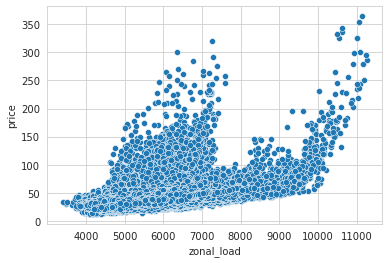

In [133]:
sns.scatterplot(data=df, x='zonal_load', y='price')

<AxesSubplot:xlabel='0', ylabel='Density'>

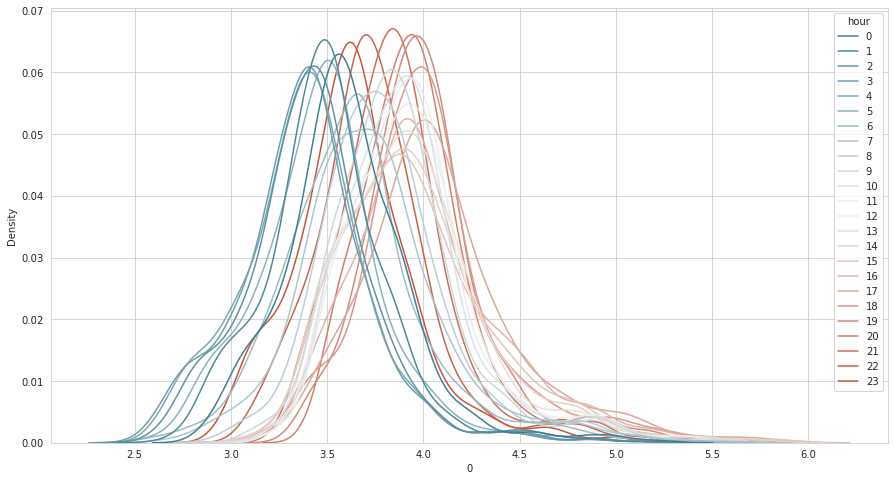

In [8]:
a = df.set_index(['day','hour']).loc[:, ['system_load','zonal_load','price']].unstack(level=1)

fig, ax = plt.subplots(figsize=(15, 8))
sns.kdeplot(data=np.log(a.price).stack().reset_index(), x=0, hue='hour', ax=ax, palette=sns.diverging_palette(220, 20, as_cmap=True))

<AxesSubplot:xlabel='hour', ylabel='0'>

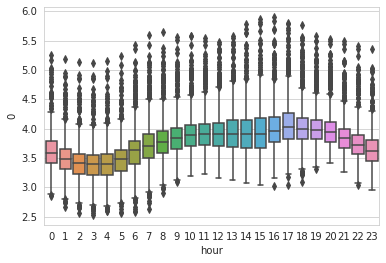

In [10]:
sns.boxplot(data=np.log(a.price).stack().reset_index(), y=0, x='hour')

<AxesSubplot:xlabel='hour', ylabel='hour'>

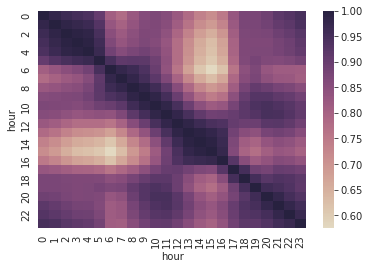

In [18]:
sns.heatmap(np.log(a.price).corr(), cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True))

<AxesSubplot:xlabel='timestamp'>

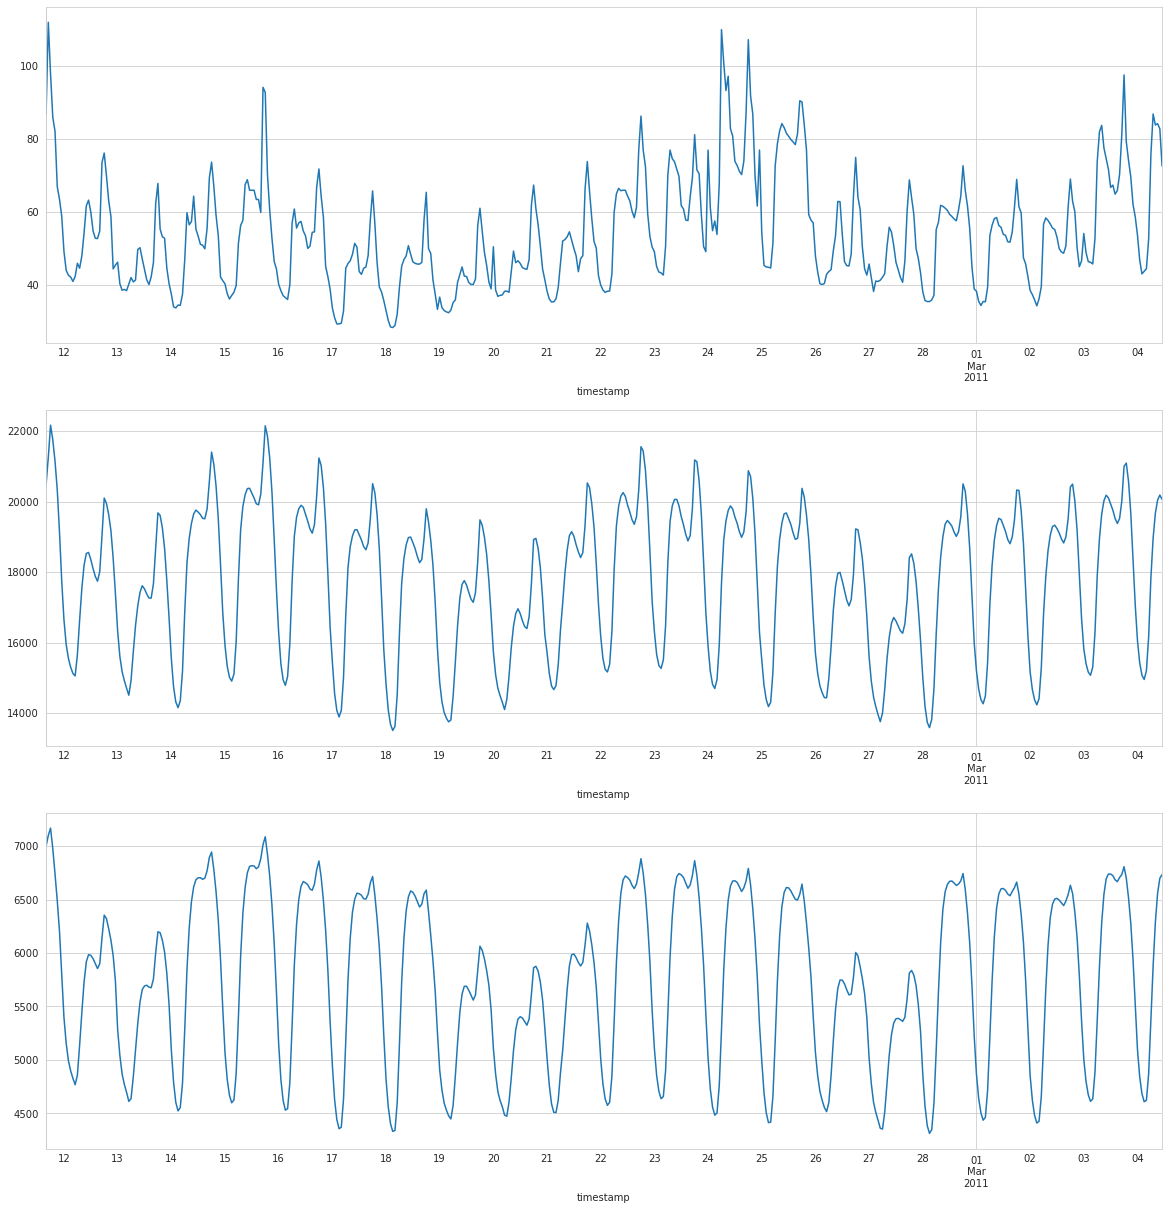

In [49]:
n1, n2 = 1000, 1500
fig, axes = plt.subplots(3, 1, figsize=(20, 21))
df.iloc[n1:n2, :].price.plot(ax=axes[0])
df.iloc[n1:n2, :].system_load.plot(ax=axes[1])
df.iloc[n1:n2, :].zonal_load.plot(ax=axes[2])